# 1. Movement with constant velocity

In [1]:
from __future__ import division, print_function, generators
import  numpy as np

### Parameters

The system under consideration is an object traveling under constant velocity. Its motion (in both time and space) can be parametrized as a straight line with intercept $x_0$ and inclination $v$. The position is measured $N$ times at time intervals $dt$, or alternatively at some fixed positions given by $k$ surfaces. 

In [2]:
N = 10
dt = 1.
v = -10.

### True trajectory

In [3]:
x0 = 100.
xtrue = np.empty((N,))
xtrue[0] = x0
for i in range(1,N):
    xtrue[i] = xtrue[i-1] + v*dt
print(xtrue)

[ 100.   90.   80.   70.   60.   50.   40.   30.   20.   10.]



The measurement is noisy and the results are normally distributed with variance $\sigma^2$. 


### Measured trajectory

In [4]:
xmeas = np.empty((N,))
print(xmeas)
sigma = 10
for i in range(0,N):
    xmeas[i] = np.random.normal(xtrue[i], sigma)
print(xmeas)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 102.32801064   96.72072239   71.63569537   67.70753625   68.68858914   59.32732019   41.56469905   31.83289643    8.86820961    5.10332773]


## Kalman Filter

### System equation
In this simplest case the state vector $\mathbf{p}_k = [x_0, v]$ at surface $k$ is left unchanged by the time evolution of the system. An alternative parametrization is given by the  The deterministic function $\mathbf{f}_k$ (which has a linear approximation $\mathbf{F}_k$ that describes how the track parameter would change from one surface to another is just the identity. Additionaly, future track parameters are affected by process noise $\mathbf{\delta}_k$. Usually only a subset of the track parameters are affected by process noise. This is expressed by multiplying the matrix representation of process noise with a projection matrix $\mathbf{P}_k$.
The covariance matrix of $\mathbf{\delta}_k$ is denoted $\mathbf{Q}_k$.



### Measurement equation

The deterministic function $\mathbf{h}_k$  with linear expansion $\mathbf{H}_k$ maps the track parameters $\mathbf{p}_k$ to measurable quantities (p.ex. space time points). The covariance of the measurement noise is denoted $\mathbf{V}_k$


Noattion:
[1] Frühwirth, Rudolf, and Meinhard Regler. _Data analysis techniques for high-energy physics_. Vol. 11. Cambridge University Press, 2000.

In [14]:
# estimated track parameters at times k
xkal = np.empty((N,))
# prediction for new track parameters based on previous ones
xpredict = np.empty((N,))
# covariance matrices (here only numbers) of the measurements
p = np.empty((N,))
# Kalman gain matrices
K = np.empty((N,))
# initial position
xpredict[0] = xkal[0] = xmeas[0]
# initial variance on prediction
p[0] = 20
# measurement error
r = sigma^2

# transformation matrix (from state to measurement)
H = 1

for i in range(1,N):
    # prediction: recursive formula
    xpredict[i] = xkal[i-1] + v*dt
    p[i] = p[i-1]
    # constructing Kalman gain matrix
    # in this case, the gain shrinks with each recursion
    # makes sense, as one outlier should not influence a prediction based on many points
    K[i] = p[i]/(p[i]+r)
    # final estimate of local track paramters based on prediction and 
    # measurement
    xkal[i] = xpredict[i] + K[i]*(xmeas[i] - H * xpredict[i])
    # update covariance
    p[i] = (1-K[i]) * p[i]


### Plot results

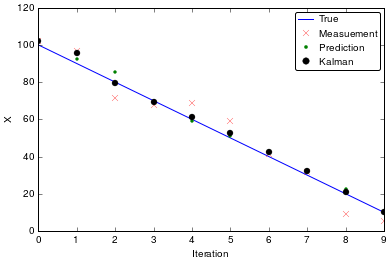

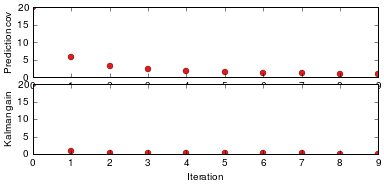

In [15]:
%matplotlib inline
import matplotlib.pyplot as plot
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas, 'rx', label = 'Measuement')
plot.plot(xpredict, 'g.',  label = 'Prediction')
plot.plot(xkal, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.legend()
plot.show()
plot.subplot(3,1,1)
plot.plot(p,'o')
plot.ylabel('Prediction cov')
plot.subplot(3,1,2)
plot.plot(K,'o')
plot.ylabel('Kalman gain')
plot.xlabel('Iteration')
plot.show()


# 2. Same problem but with unknown velocity


In [33]:
xpredict2 = np.matrix (np.linspace(0,10,N*2).reshape((2, N)))
xkal2 = np.matrix (np.linspace(0,10,N*2).reshape((2, N)))
# initial position and velocity
xpredict2[:,0] = xkal2[:,0] = np.array ( [[xmeas[0]], [np.random.normal(v,1.5) ] ])
# initial variance on prediction
p2 = np.matrix ( [[20, 0],
                    [0, 20]] )
# measurement error
r = np.matrix([[sigma^2]])

# prediction matrix
A = np.matrix ( [[1, dt],
                 [0, 1]] )
# transformation matrix (from measurement to state vector)
H = np.matrix ( [[1 , 0]] )

for i in range(1,N):
    # prediction: recursive formula
    xpredict2[:,i] = np.dot(A, xkal2[:,i-1] )
    p2 = A*p2*A.T
    K2 = np.dot(p2*H.T, np.linalg.inv(H*p2*H.T+r))
    xkal2[:,i] = xpredict2[:,i] + K2*(xmeas[i] - H*xpredict2[:,i])
    p2 = (np.identity(2)-K2) * p2

matrix([[ 2.,  0.],
        [ 0.,  2.]])

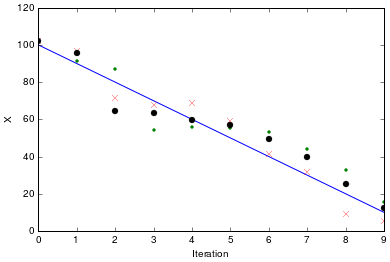

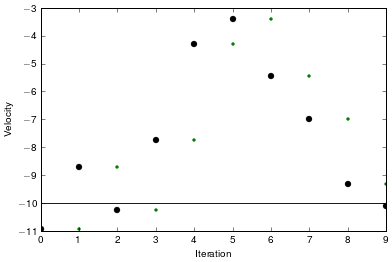

In [34]:
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas, 'rx', label = 'Measuement')
plot.plot(xpredict2[0].T, 'g.',  label = 'Prediction')
plot.plot(xkal2[0].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.show()

plot.axhline(v)
plot.plot(xpredict2[1].T, 'g.',  label = 'Prediction')
plot.plot(xkal2[1].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('Velocity')
plot.show()

# 3. Same problem but with unknown velocity that is also measured

#### In principle should be better than 2. - why isn't ?? Additional measurement (on x_velocity) should improve kalman\

But kalman already knows about the velocity from the transformation matrix A / the initial value we give to xkal and xpredict?


In [10]:
xmeas3 = np.matrix (np.linspace(0,10,N*2).reshape((2, N)))
sigma3 = 1
for i in range(0,N):
    xmeas3[0,i] = np.random.normal(xtrue[i], sigma)
    xmeas3[1,i] = np.random.normal(v, sigma3)
print(xmeas3.T)

[[ 103.60567662   -8.84731285]
 [  85.49123988  -11.05810798]
 [  83.38468372   -9.58432119]
 [  75.63816155  -10.20933536]
 [  75.13422356  -10.81983608]
 [  42.14740608  -10.86214536]
 [  46.26307261   -8.7409006 ]
 [  49.16011052   -9.47757818]
 [  10.31606038  -10.27954391]
 [  30.13114809  -10.88993718]]


In [11]:
xpredict3 = np.matrix (np.linspace(0,10,N*2).reshape((2, N)))
xkal3 = np.matrix (np.linspace(0,10,N*2).reshape((2, N)))
# initial position
xpredict3[:,0] = xkal3[:,0] = np.array ( [[xmeas3[0,0]], [xmeas3[1,0]] ] )
# initial variance on prediction
p2 = np.matrix ( [[20, 0],
                    [0, 20]] )
# measurement error
r3 = np.matrix([[0.001*sigma*sigma, 0],
                 [0  , 0.001*sigma3*sigma3]])

# prediction matrix
A = np.matrix ( [[1, dt],
                    [0, 1]] )
# transformation matrix (from measurement to state vector)
H3 = np.matrix ( [[1 , 0],
                   [0, 1]] )

for i in range(1,N):
    # prediction: recursive formula
    xpredict3[:,i] = np.dot(A, xkal3[:,i-1] )
    print(xpredict3[:,i].T)
    p2 = A*p2*A.T
    K2 = p2*H3.T * np.linalg.inv(H3*p2*H3.T+r3)
    xkal3[:,i] = xpredict3[:,i] + K2*(xmeas3[:,i] - H3*xpredict3[:,i])
    p2 = (np.identity(2)-K2) * p2

[[ 94.75836377  -8.84731285]]
[[ 74.46799632 -11.05834848]]
[[ 68.99598243 -10.30083158]]
[[ 61.01042002 -10.24847199]]
[[ 54.06658806 -10.33712239]]
[[ 40.89833311 -10.48686533]]
[[ 32.37134241 -10.18240574]]
[[ 25.25028598 -10.01635781]]
[[ 12.94787292 -10.10973128]]


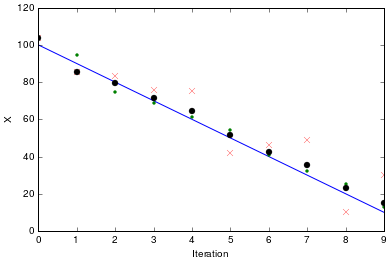

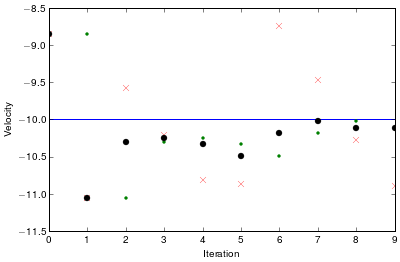

In [12]:
plot.plot(xtrue, 'b-', label = 'True')
plot.plot(xmeas3[0].T, 'rx', label = 'Measuement')
plot.plot(xpredict3[0].T, 'g.',  label = 'Prediction')
plot.plot(xkal3[0].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('X')
plot.show()

plot.axhline(v)
plot.plot(xpredict3[1].T, 'g.',  label = 'Prediction')
plot.plot(xmeas3[1].T, 'rx', label = 'Measuement')
plot.plot(xkal3[1].T, 'ko', label = 'Kalman')
plot.xlabel('Iteration')
plot.ylabel('Velocity')
plot.show()

In [ ]:
prin

In [13]:
np.linalg.inv(np.matrix([[1,0], [0,1]]))

matrix([[ 1.,  0.],
        [ 0.,  1.]])

In [35]:
%pwd

u'/afs/cern.ch/user/v/vavolkl/moritat'